# 直線趨勢線與技術型態的基礎：轉折點

## 尋找轉折點函式

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import mplfinance as mpf
import numpy as np

In [2]:
# 來源 ： https://github.com/neurotrader888/TechnicalAnalysisAutomation/blob/main/rolling_window.py
from myutils.TurningPoints import rw_extremes

In [3]:
# 用到scipy套件的信號處理argrelextrema函式
from scipy.signal import argrelextrema

def FindingTurningPoints(prices, mode = 'close', order = 1, smoothing = 1,real_body = False,rolling_window = False) :
    # 價格資料確認與處理
    if prices is None and type(prices) is not DataFrame:
        return None
    in_prices = prices.copy()
    if 'Open' not in in_prices.columns or 'High' not in in_prices.columns or 'Low' not in in_prices.columns or 'Close' not in in_prices.columns :
        return None    
    if 'Date' not in in_prices.columns and in_prices.index.dtype == 'datetime64[ns]' :
        in_prices.index.name = 'Date'
        in_prices = in_prices.reset_index()
    if 'Date' not in in_prices.columns :
        return None
    # 模式確認與處理
    if mode == 'high_low' :
        prices_high=np.array(in_prices['High'])
        prices_low=np.array(in_prices['Low'])
    elif mode == 'close' :
        if smoothing > 1 :
            # 若為平滑化的收盤價,使用向前與向後傳播非空值的方法填充空(NaN)值;並將窗口標籤設置為窗口索引的中心，以正確反映趨勢
            smooth_close_prices = np.array(in_prices['Close'].rolling(window=smoothing,center=True).mean().fillna(method='bfill').fillna(method='ffill'))
            prices_high=smooth_close_prices
            prices_low=smooth_close_prices
        else :
            prices_close=np.array(in_prices['Close'])
            prices_high=prices_close
            prices_low=prices_close
    elif mode == 'open_close' :
        prices_oepn  = np.array(in_prices['Open'])
        prices_close = np.array(in_prices['Close'])
        prices_high_list = []
        prices_low_list  = []
        for idx in range(0,len(prices_oepn)) :
            if prices_oepn[idx] >= prices_close[idx] :
                prices_high_list.append(prices_oepn[idx])
                prices_low_list.append(prices_close[idx])
            else :
                prices_high_list.append(prices_close[idx])
                prices_low_list.append(prices_oepn[idx])
        prices_high = np.array(prices_high_list)
        prices_low  = np.array(prices_low_list)
    else :
        return None
    if len(prices_high) != len(prices_low) :
        return None
    total_price = len(prices_high)
    # 找出轉折點，並保存其索引
    if rolling_window is True :
        _,local_min = rw_extremes(prices_low,order)
        local_max,_ = rw_extremes(prices_high,order)
        local_min = np.array(local_min)
        local_max = np.array(local_max)
        local_min_idx = local_min[:,1]
        local_max_idx = local_max[:,1]
    else :
        local_min_idx = argrelextrema(prices_low,np.less,order=order)[0]
        local_max_idx = argrelextrema(prices_high,np.greater,order=order)[0]
        local_min_idx = np.array(local_min_idx)
        local_max_idx = np.array(local_max_idx)
    # 合併局部最大(波峰)與局部最小(波谷)轉折點
    local_max_min_point=[]
    point_type = ''
    for idx in range(total_price):
        if idx in local_max_idx :
            if point_type != 'HI' :
                # 波谷轉波峰
                point_type = 'HI'
                if mode == 'high_low' :
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['High'],point_type))
                elif mode == 'close' :
                    real_body_price = in_prices.iloc[idx]['Close']
                    if real_body is True and in_prices.iloc[idx]['Open'] > in_prices.iloc[idx]['Close'] :
                        real_body_price = in_prices.iloc[idx]['Open']
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
                elif mode == 'open_close' :
                    real_body_price = in_prices.iloc[idx]['Close']
                    if in_prices.iloc[idx]['Open'] >= in_prices.iloc[idx]['Close'] :
                        real_body_price = in_prices.iloc[idx]['Open']
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
            else :
                # 同為波峰，選最高者
                previous_price = local_max_min_point[-1][2]
                if mode == 'high_low' :
                    current_price = in_prices.iloc[idx]['High']
                    if current_price > previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 新增目前這一筆
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['High'],point_type))
                elif mode == 'close' :
                    current_price = in_prices.iloc[idx]['Close']
                    if current_price > previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 新增目前這一筆
                        real_body_price = in_prices.iloc[idx]['Close']
                        if real_body is True and in_prices.iloc[idx]['Open'] > in_prices.iloc[idx]['Close'] :
                            real_body_price = in_prices.iloc[idx]['Open']
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
                elif mode == 'open_close' :
                    current_price = in_prices.iloc[idx]['Close']
                    if in_prices.iloc[idx]['Open'] >= in_prices.iloc[idx]['Close'] :
                        current_price = in_prices.iloc[idx]['Open']
                    if current_price > previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 新增目前這一筆
                        real_body_price = in_prices.iloc[idx]['Close']
                        if in_prices.iloc[idx]['Open'] >= in_prices.iloc[idx]['Close'] :
                            real_body_price = in_prices.iloc[idx]['Open']
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
        elif idx in local_min_idx :
            if point_type != 'LO' :
                # 波峰轉波谷
                point_type = 'LO'
                if mode == 'high_low' :
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['Low'],point_type))
                elif mode == 'close' :
                    real_body_price = in_prices.iloc[idx]['Close']
                    if real_body is True and in_prices.iloc[idx]['Open'] < in_prices.iloc[idx]['Close'] :
                        real_body_price = in_prices.iloc[idx]['Open']
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
                elif mode == 'open_close' :
                    real_body_price = in_prices.iloc[idx]['Close']
                    if in_prices.iloc[idx]['Open'] < in_prices.iloc[idx]['Close'] :
                        real_body_price = in_prices.iloc[idx]['Open']
                    local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
            else :
                # 同為波谷，選最低者
                previous_price = local_max_min_point[-1][2]
                if mode == 'high_low' :
                    current_price = in_prices.iloc[idx]['Low']
                    if current_price < previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 改新增目前這一筆
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],in_prices.iloc[idx]['Low'],point_type))
                elif mode == 'close' :
                    current_price = in_prices.iloc[idx]['Close']
                    if current_price < previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 改新增目前這一筆
                        real_body_price = in_prices.iloc[idx]['Close']
                        if real_body is True and in_prices.iloc[idx]['Open'] < in_prices.iloc[idx]['Close'] :
                            real_body_price = in_prices.iloc[idx]['Open']
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
                elif mode == 'open_close' :
                    current_price = in_prices.iloc[idx]['Close']
                    if in_prices.iloc[idx]['Open'] < in_prices.iloc[idx]['Close'] :
                        current_price = in_prices.iloc[idx]['Open']
                    if current_price < previous_price :
                        # 移除前一筆
                        previous_point = local_max_min_point.pop()
                        # 改新增目前這一筆
                        real_body_price = in_prices.iloc[idx]['Close']
                        if in_prices.iloc[idx]['Open'] < in_prices.iloc[idx]['Close'] :
                            real_body_price = in_prices.iloc[idx]['Open']
                        local_max_min_point.append((idx,in_prices.iloc[idx]['Date'],real_body_price,point_type))
    local_max_min_point = pd.DataFrame(local_max_min_point,columns=['DateIndex','Date','Price','Type'])
    # 轉換為輸出格式
    max_min = local_max_min_point.set_index('DateIndex')
    return local_min_idx,local_max_idx,max_min

## 程式實作：人工方式選擇轉折點以繪製直線趨勢線

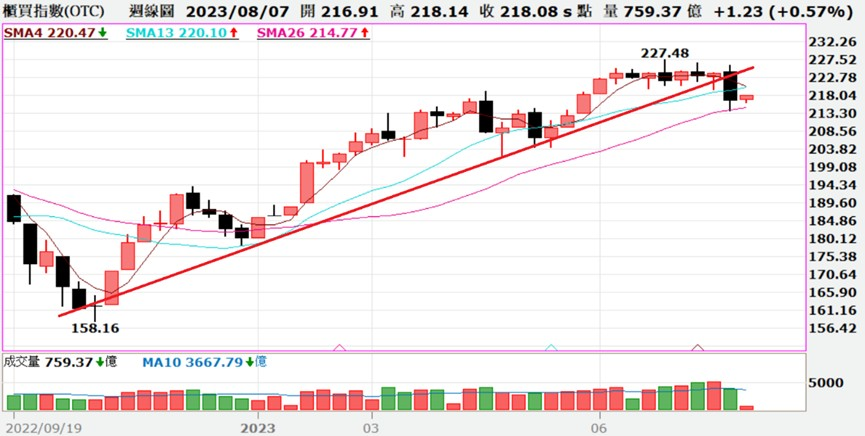

In [4]:
##### 使用2022年9月19日到2023年8月8日的週K線資料 #####

# 載入從「好神通PLUS」輸出的Excel檔
df = pd.read_excel('Day9.xlsx')

# 保存K線的基本資訊(開、高、低、收、量)
df_k_line = df.drop(columns=['SMA4','SMA13','MA6','MA12', 'DIF6-12','MACD2','OSC','K(6,3)','D(6,3)'])

# 保存價的移動平均線
df_sma = df.drop(columns=['開盤價','最高價','最低價','收盤價','成交量','MA6','MA12', 'DIF6-12','MACD2','OSC','K(6,3)','D(6,3)']) 

# 將K線的Columns的名稱由中文改為英文
df_k_line = df_k_line.rename(columns={'時間':'Date','開盤價':'Open','最高價':'High','最低價':'Low','收盤價':'Close','成交量':'Volume'})

# 將價的移動平均線的Columns的名稱由中文改為英文
df_sma = df_sma.rename(columns={'時間':'Date'})

# 將K線的Date設為Index
df_k_line.set_index(pd.to_datetime(df_k_line['Date'],format='%Y-%m-%d'),inplace=True)
df_k_line = df_k_line.drop(columns=['Date'])

# 將價的移動平均線的Date設為Index
df_sma.set_index(pd.to_datetime(df_sma['Date'],format='%Y-%m-%d'),inplace=True)
df_sma = df_sma.drop(columns=['Date'])

                Date   Price Type
DateIndex                        
4         2022-10-17  161.62   LO
11        2022-12-05  192.15   HI
14        2022-12-26  180.34   LO
29        2023-04-17  216.49   HI
33        2023-05-15  206.81   LO
41        2023-07-10  224.38   HI


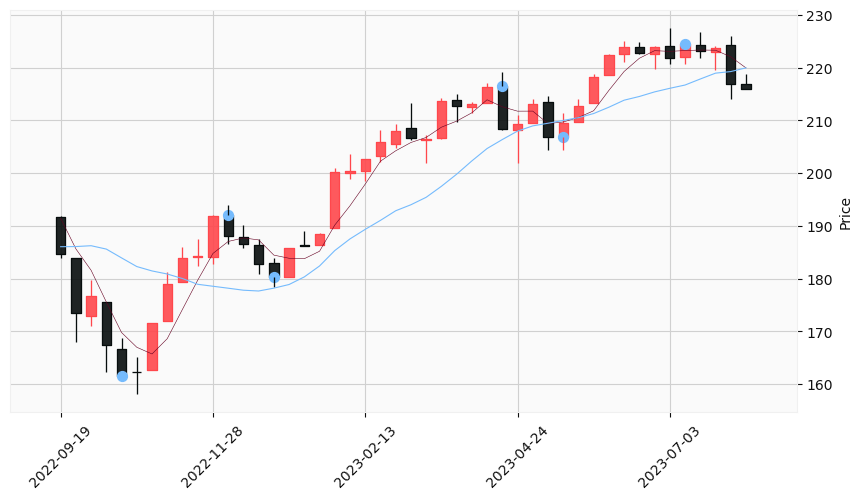

In [5]:
# 尋找轉折點
_,_,max_min = FindingTurningPoints(df_k_line,'open_close',order=2)
# 印出轉折點資訊
print(max_min)

# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定移動平均線與轉折點    
turning_points_len = len(np.array(df_k_line['Close']))
turning_points = np.array([np.nan]*turning_points_len)
for point in max_min.iterrows() :
    turning_points[point[0]] = point[1]['Price']    
apds = [
    mpf.make_addplot(turning_points,type='scatter',marker='o',markersize=50,color='xkcd:sky blue'),
    mpf.make_addplot(df_sma['SMA4'],width=0.4,color='xkcd:maroon'),
    mpf.make_addplot(df_sma['SMA13'],width=0.8,color='xkcd:sky blue')
]

# 繪出K線圖與轉折點，以利人眼判斷
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds, datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)

In [6]:
def date_to_index(df_in,date_in) :
    number_array = df_in.index == date_in
    idx = 0
    for number_index in number_array :
        if number_index == True :
            break
        idx = idx + 1
    return idx

In [7]:
# 從找到的轉折點，設定上升趨勢線
up_trendline_x = [4,33]
up_trendline_y = [max_min.loc[up_trendline_x[0]]['Price'],max_min.loc[up_trendline_x[1]]['Price']]
slope,intercept = np.polyfit(up_trendline_x,up_trendline_y,1)
up_trendline_start_date = '2022-10-17'
up_trendline_start_price = slope * date_to_index(df_k_line,'2022-10-17') + intercept
up_trendline_end_date = '2023-08-07'
up_trendline_end_price = slope * date_to_index(df_k_line,'2023-08-07') + intercept

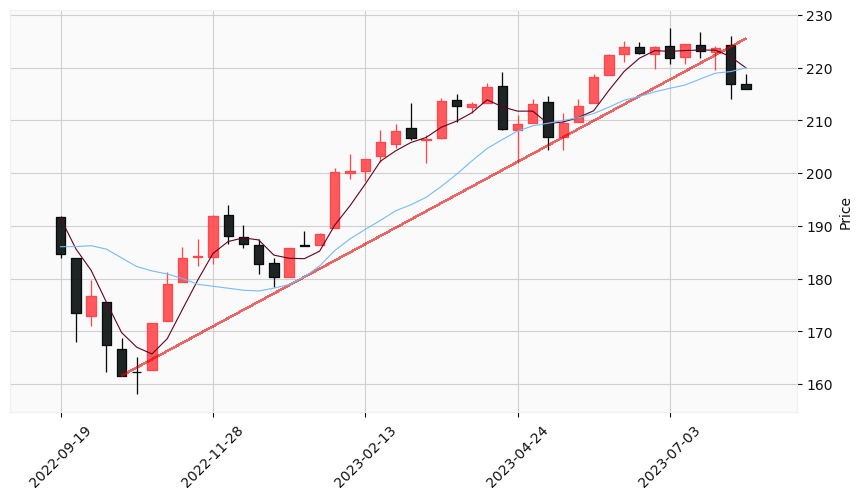

In [8]:
# 設定K線格式
mc = mpf.make_marketcolors(up='xkcd:light red', down='xkcd:almost black', inherit=True)
s  = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc)

# 設定上升趨勢線
seq_of_seq_of_points=[
    [(up_trendline_start_date,up_trendline_start_price),(up_trendline_end_date,up_trendline_end_price)]
                     ]

# 設定移動平均線
apds = [
    mpf.make_addplot(df_sma['SMA4'],width=0.8,color='xkcd:maroon'),
    mpf.make_addplot(df_sma['SMA13'],width=0.8,color='xkcd:sky blue')
]

# 繪出K線圖
kwargs = dict(type='candle', style=s, figratio=(19,10), addplot=apds,alines=dict(alines=seq_of_seq_of_points, linewidths=1.0, colors='xkcd:red', alpha=0.6), datetime_format='%Y-%m-%d')
mpf.plot(df_k_line,**kwargs)